In [29]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params

In [150]:
def logPr_gaussian(logL, X_logL, mean, covinv, theta):
    Xstar = X_logL(logL, theta)
    return - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean) 

def logPr_bayes(logL, X_logL, logLprime, mean, covinv, theta):
    Xstar = X_logL(logL, theta)
    log_abs_fprimes = np.log(abs(logLprime(Xstar, theta)))
    return - np.sum(log_abs_fprimes) - 1/2 * (Xstar - mean).T @ covinv @ (Xstar - mean)


def minimise_ls(logL, X_logL, mean, theta0):
    def loss(theta):
        return logL - X_logL(mean, theta)
    return least_squares(loss, theta0)

def minimise_gaussian(logL, X_logL, mean, covinv, x0):
    def func(theta):
        return - logPr_gaussian(logL, X_logL, mean, covinv, theta)
    solution = minimize(func, x0)
    return solution

def minimise_bayes(logL, X_logL, logLprime, mean, covinv, x0):
    def func(theta):
        return - logPr_bayes(logL, X_logL, logLprime, mean, covinv, theta)
    solution = minimize(func, x0)
    return solution

In [178]:
def compare_bayes_ls(nk, theta_true, func, inverse, prime, mean_X, covinv_X, repeats=10):
    repeats = 10
    bs = np.zeros((repeats, len(theta_true)))
    ls = np.zeros((repeats, len(theta_true)))
    for i in range(repeats):
        Xs = generate_Xs(nk)
        y = func(Xs, theta_true)
        bs[i] = minimise_bayes(y, inverse, prime, mean_X, covinv_X, theta_true).x
        ls[i] = minimise_ls(y, func, mean_X, theta_true).x
    print(f'bayes: {bs.mean(axis=0)} +/- {bs.std(axis=0)}') 
    print(f'ls: {ls.mean(axis=0)} +/- {ls.std(axis=0)}') 

def plot_bayes_ls(nk, theta_true, func, inverse, prime, mean_X, covinv_X):
    Xs = generate_Xs(nk)
    y = func(Xs, theta_true)

    theta_bayes = minimise_bayes(y, inverse, prime, mean_X, covinv_X, theta_true).x
    theta_ls = minimise_ls(y, func, mean_X, theta_true).x

    plt.plot(Xs, y, 'x', ms=2)
    plt.plot(Xs, func(Xs, theta_bayes), label='bayes')
    plt.plot(Xs, func(Xs, theta_ls), label='ls')
    plt.legend();
    print(f'bayes: {theta_bayes}')
    print(f'ls: {theta_ls}')

    return Xs, theta_bayes, theta_ls

In [123]:
def likelihood_simple(X, d):
    return -X**(2/d)

def likelihood_simple_inverse(logL, d):
    return (-logL)**(d/2)

def likelihood_simple_prime(X, d):
    return - (2/d) * X**(2/d - 1)


def likelihood_middle(X, theta):
    d, sigma = theta
    return - X**(2/d)/(2*sigma**2)

def likelihood_middle_inverse(logL, theta):
    d, sigma = theta
    return (-2*sigma**2*logL)**(d/2)

def likelihood_middle_prime(X, theta):
    d, sigma = theta
    return - (1/d*sigma**2) * X**(2/d - 1)

In [124]:
def simple_logL_logX(logX, d):
    X = np.exp(logX)
    return -X**(2/d)

def simple_logX_logL(logL, d):
    return np.log((-logL)**(d/2))

def simple_logLprime_logX(logX, d):
    X = np.exp(logX)
    return - 2/d * X**(2/d - 1)

def logPr_bayes_logX(logL, mean, covinv, d):
    logXstar = simple_logX_logL(logL, d)
    abs_fprimes = abs(simple_logLprime_logX(logXstar, d))
    return - np.sum(abs_fprimes) - 1/2 * (logXstar - mean).T @ covinv @ (logXstar - mean)

In [40]:
# nk = 500 * np.ones(2000)
nk = data_at_iteration(samples_g_1, 1000)[0]
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

### Try on $X^{2/d}$

Bayes and least squares give same (correct) mean over many repeats

Bayes less consistent - greater spread in the mean

In [146]:
theta_true = np.array([10])
compare_bayes_ls(nk, theta_true, likelihood_simple, likelihood_simple_inverse, likelihood_simple_prime, mean_X, covinv_X, repeats=50)

bayes: [10.0080316] +/- [0.25976617]
ls: [9.98110937] +/- [0.23917312]


bayes: [10.30932129]
ls: 10.29348723437081


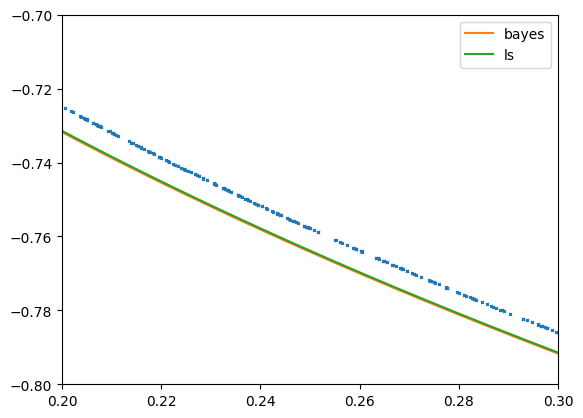

In [113]:
plot_bayes_ls(nk, 10, likelihood_simple, likelihood_simple_inverse, likelihood_simple_prime, mean_X, covinv_X)
plt.xlim(0.2, 0.3)
plt.ylim(-0.8, -0.7);

In [82]:
b = 0
l = 0
for i in range(10):
    dtrue = 10
    repeats = 20
    bs = np.zeros(repeats)
    ls = np.zeros(repeats)
    for i in range(repeats):
        Xs = generate_Xs(nk)
        y = likelihood_simple(Xs, dtrue)
        bs[i] = minimise_bayes(y, likelihood_simple_inverse, likelihood_simple_prime, mean_X, covinv_X, dtrue).x
        ls[i] = minimise_ls(y, likelihood_simple, mean_X, dtrue).x
    if bs.std() < ls.std():
        b += 1
    else:
        l += 1
print('b', b)
print('l', l)

b 1
l 9


### Try on $X^{2/d}/2\sigma^2$

In [147]:
compare_bayes_ls(nk, np.array([10, 0.1]), likelihood_middle, likelihood_middle_inverse, likelihood_middle_prime, mean_X, covinv_X, repeats=50)

bayes: [10.13383617  0.09996649] +/- [3.04698484e-01 8.25581946e-06]
ls: [10.10227254  0.10006395] +/- [0.26541825 0.00029172]


bayes: [10.27290964  0.09998277]
ls: [10.1285252   0.10036184]


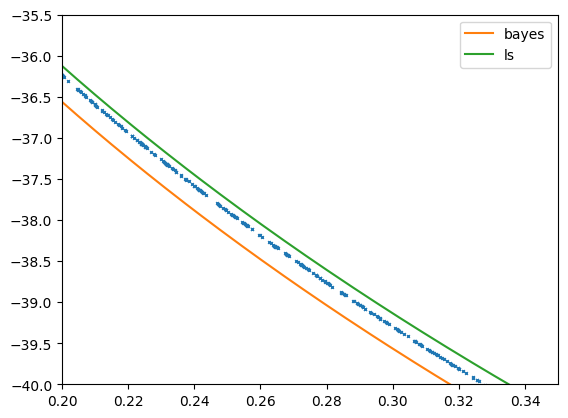

In [182]:
Xs, theta_b, theta_l = plot_bayes_ls(nk, np.array([10, 0.1]), likelihood_middle, likelihood_middle_inverse, likelihood_middle_prime, mean_X, covinv_X)
plt.xlim(0.2, 0.35)
plt.ylim(-40, -35.5);

In [186]:
logPr_bayes(likelihood_middle(Xs, theta_true), likelihood_middle_inverse, likelihood_middle_prime, mean_X, covinv_X, theta_true)

7593.058349064518

In [185]:
logPr_bayes(likelihood_middle(Xs, theta_true), likelihood_middle_inverse, likelihood_middle_prime, mean_X, covinv_X, theta_b)

7596.921780916536